2/5/25 Lab 0 EAS 6995 Jessica Smith

Code adapted from BEE 6310 (Fall 2024) Assignmnet 6

In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from numpy import linalg as ln #to compute eigen values/ vectors
import netCDF4 as nc
import pandas as pd
from sklearn.decomposition import PCA

In [5]:
# These data come from the National Oceanic and Atmospheric Administration's (NOAA's) Extended Reconstructed SST v5 dataset, and contain:
#   - The date of monthly SST observations from 1949-10-01 through 2024-07-01 (first column)
#   - A time series of SSTs (in degrees C) for 2-degree latitude by 2-degree longitude grid cells all around the world (remaining columns)
SST_df_ = pd.read_csv('SST_df.csv')
SST_df_date = SST_df_['date']

SST_df = SST_df_.drop('date', axis=1)

lat_lon = pd.read_csv('latitude_longitude_sst.csv')

In [6]:
SST_mean = SST_df.mean()
SST_std = SST_df.std()

SST anomalies (differences from long-term average conditions) during a specific season (late fall - early winter) 

In [7]:
SST_df_date = pd.to_datetime(SST_df_['date'])
# Create a DataFrame for dates with month and year
SST_df_date = pd.DataFrame({'date': SST_df_date})
SST_df_date['month'] = SST_df_date['date'].dt.month
SST_df_date['year'] = SST_df_date['date'].dt.year

# Center each grid cell by subtracting long-term monthly means
sst_df_centered = SST_df.copy()  # Initialize a copy for centering

for month in range(1, 13):
    # Identify rows corresponding to the current month
    month_mask = SST_df_date['month'] == month
    
    # Calculate the long-term mean for each grid cell for this month
    month_means = SST_df.loc[month_mask].mean(axis=0)

    # Subtract the monthly mean from the respective rows
    sst_df_centered.loc[month_mask] -= month_means

# Calculate OND anomalies for each year
OND_anomalies = []

for year in range(1949, 2024):  # Adjust the year range based on your dataset
    # Identify rows for October, November, and December of the current year
    ond_mask = (SST_df_date['year'] == year) & (SST_df_date['month'].isin([10, 11, 12]))
    
    # Ensure there are exactly 3 months of data for OND
    if ond_mask.sum() == 3:
        # Calculate the OND mean anomaly for each grid cell
        OND_mean = sst_df_centered.loc[ond_mask].mean(axis=0)
        OND_anomalies.append(OND_mean)

# Convert OND anomalies into a DataFrame
sst_df_centered_OND = pd.DataFrame(OND_anomalies, index=range(1949, 2024))

In [14]:
pca = PCA(n_components=10)  # Extract first 10 PCs
pca_result = pca.fit(sst_df_centered_OND)

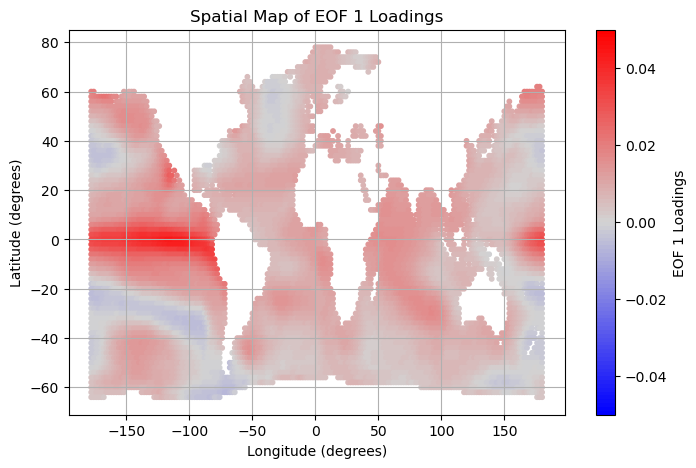

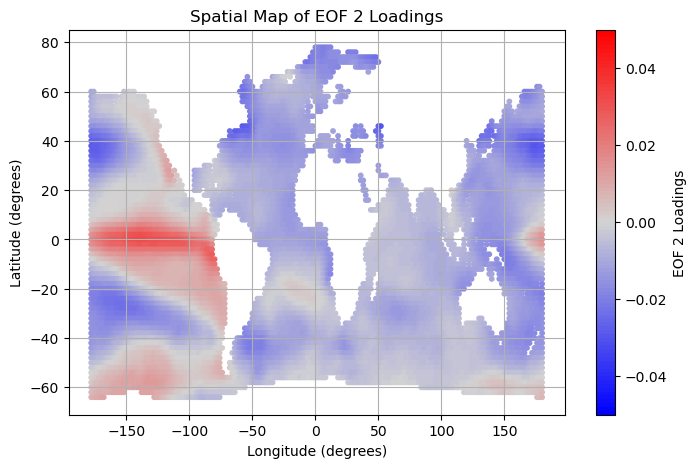

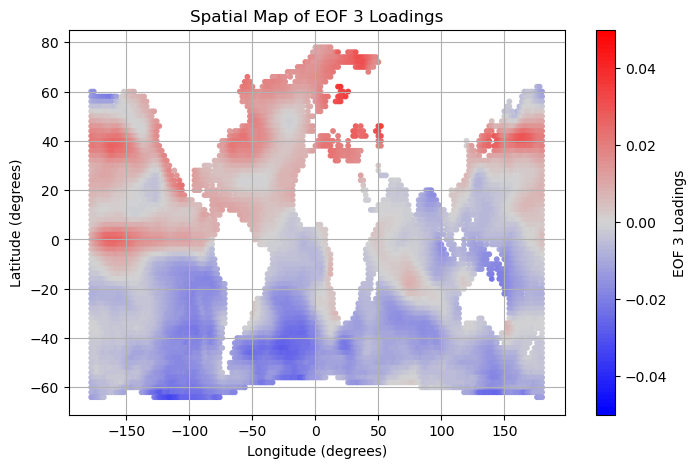

In [18]:
import matplotlib.colors as mcolors
# Extract the loading values (EOFs) for the selected PCs
selected_pcs = [0, 1, 2]  
W = np.transpose(pca.components_)[:, selected_pcs]

# Define the custom colormap
colors = ['blue', 'lightgrey', 'red']  # Color transitions
n_bins = 100  # Number of bins for the colormap
cmap_name = 'custom_blue_white_red'
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Loop through selected PCs and create spatial maps
selected_pcs = [0, 1, 2] 
for i, pc in enumerate(selected_pcs):
    plt.figure(figsize=(8, 5))
    plt.scatter(lat_lon['lon'], lat_lon['lat'], c=W[:, i], cmap=custom_cmap, s=10, vmin=-0.05, vmax=0.05)
    plt.colorbar(label=f'EOF {pc+1} Loadings')
    plt.title(f'Spatial Map of EOF {pc+1} Loadings')
    plt.xlabel('Longitude (degrees)')
    plt.ylabel('Latitude (degrees)')
    plt.grid()
    plt.show()

Text(0, 0.5, 'PC3 Value')

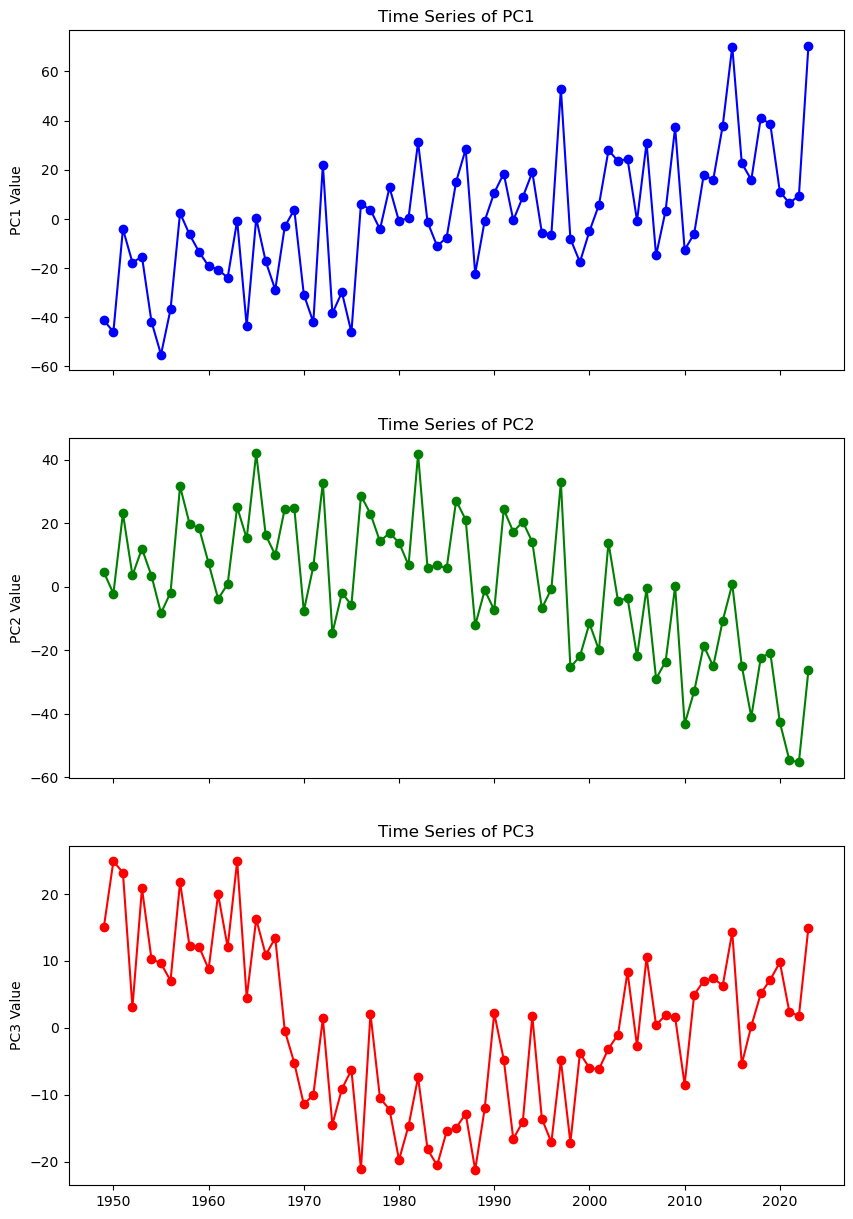

In [21]:
# Assume PC time series are stored in pca_result.transform(sst_df_centered_OND)
pc_time_series = pca_result.transform(sst_df_centered_OND)  # Shape: (n_samples, n_components)
selected_pcs = [0, 1, 2]  # PCs to plot

# Create a 3-panel figure
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
# Plot time series of the first selected PC
axes[0].plot(range(1949, 2024), pc_time_series[:, selected_pcs[0]], marker='o', linestyle='-', color='b')
axes[0].set_title('Time Series of PC1')
axes[0].set_ylabel('PC1 Value')

# Plot time series of the second selected PC
axes[1].plot(range(1949, 2024), pc_time_series[:, selected_pcs[1]], marker='o', linestyle='-', color='g')
axes[1].set_title('Time Series of PC2')
axes[1].set_ylabel('PC2 Value')

# Plot time series of the third selected PC
axes[2].plot(range(1949, 2024), pc_time_series[:, selected_pcs[2]], marker='o', linestyle='-', color='r')
axes[2].set_title('Time Series of PC3')
axes[2].set_ylabel('PC3 Value')

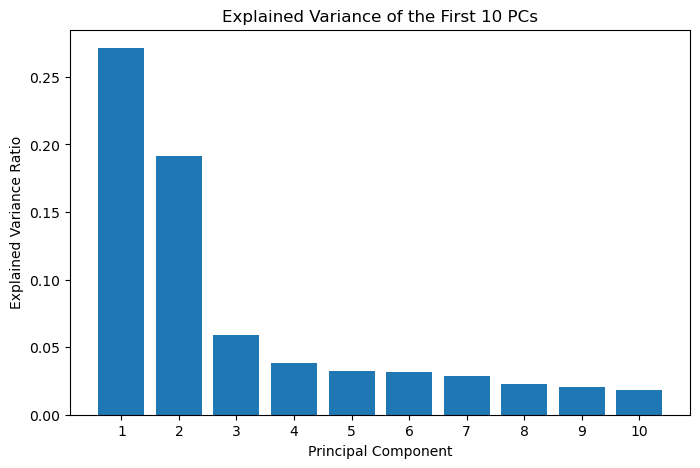

In [ ]:
# Explained variance for each PC
explained_variance = pca_result.explained_variance_ratio_  

plt.figure(figsize=(8, 5))
plt.bar(range(1, 11), explained_variance[:10])
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance of the First 10 PCs')
plt.xticks(range(1, 11))
plt.show()

Chat GPT (OpenAI, 2024) was used to help make and troubleshoot this code